# Vehicle Detection

### Project 5 - Self Driving Car Nanodegree

First, the required packages need to be imported.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
import glob
import cv2
from IPython.display import HTML
from collections import deque
from moviepy.editor import VideoFileClip

%matplotlib inline

In [6]:
cv2.__version__

'3.1.0'

---

There were many ideas introduced for this project and I tried to implement as many as possible. The goals/workflow for this project were:
1. Define Features: Perform HOG feature extraction on a labeled training set images.
2. Define Classifier: Train a Linear SVM classifier.
3. Detect Vehicles: Use a sliding window technique combined with the classifier to determine whether the window contains a vehicle or not.
4. Remove Duplicates: Create a heatmap to remove duplicates.
5. Track Vehicles: Track vehicles and predict their future trajectory based on past centroid locations.
6. Apply to Video: Run the pipeline on each frame and detect vehicles.

In [7]:
from skimage.feature import hog
from skimage.transform import resize
from scipy.ndimage.measurements import label
from collections import deque

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [18]:
class FeatureTrack(object):
    '''
    Perform feature extraction by searching regions within an image.
    '''
    
    def __init__(self, image, orientation=10, pixels_per_cell=8, cells_per_block=2):
        '''
        Initialize.
        
        Parameters
        ----------
        image           : Image for feature extraction
        orientation     : HOG orientation
        pixels_per_cell : HOG pixels per cell
        cells_per_block : HOG cells per block
        '''

        # Initialize hog features and pixels per cell
        self.hog_features = []
        self.pixels_per_cell = pixels_per_cell
        
        # Initialize image and get height, width, and color of the image
        self.image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        (self.h, self.w, self.c) = self.image.shape
        
        # For each color channel run HOG and append to hog_features
        for channel in range(self.c):
            self.hog_features.append(hog(self.image[:,:, channel], orientations = orientation,
                                         pixels_per_cell = (pixels_per_cell, pixels_per_cell), cells_per_block = (cells_per_block, cells_per_block),
                                         transform_sqrt=True, visualise=False, feature_vector=False))
        
        # Convert hog_features to numpy array
        self.hog_features = np.asarray(self.hog_features)
   
    # bin_spatial and color_hist adapted from classroom
    
    def bin_spatial(self, image, size=(32, 32)):
        """
        Computes the spatial vector.

        Parameters
        ----------
        image   : Image to get spatial vector from
        size    : Size of the kernel

        Returns
        -------
        Spatial vector.
        """
    
        return cv2.resize(image, size).ravel()

    def color_hist(self, image, nbins=32, bins_range=(0, 256)):
        """
        Uses the color channel histogram to determine the feature vector.
        
        Parameters
        ----------
        image       : Image to get spatial vector from
        nbins       : Number of bins for the histogram
        bins_range  : Range for bins
        
        Returns
        -------
        Color histogram feature vector.
        """
        
        # Compute the histograms separately for each color channel
        ch1_hist = np.histogram(image[:, :, 0], bins=nbins, range=bins_range)
        ch2_hist = np.histogram(image[:, :, 1], bins=nbins, range=bins_range)
        ch3_hist = np.histogram(image[:, :, 2], bins=nbins, range=bins_range)
        
        # Concatenate the histograms into a single feature vector
        return np.concatenate((ch1_hist[0], ch2_hist[0], ch3_hist[0]))
    
    def get_hog(self, x, y, s):
        '''
        Gets HOG features for a specified region of the image.
        
        Parameters
        ----------
        x : x coordinate on the image
        y : y coordinate on the image
        s : size of the region (square)
        
        Returns
        -------
        HOG vector
        '''
        
        s_hog = (s // self.pixels_per_cell) - 1
        
        x_hog = max((x // self.pixels_per_cell) - 1, 0)
        if x_hog + s_hog > self.hog_features.shape[2]:
            x_hog = self.hog_features.shape[2] - s_hog
        else:
            x_hog

        y_hog = max((y // self.pixels_per_cell) - 1, 0)

        if y_hog + s_hog > self.hog_features.shape[1]:
            y_hog = self.hog_features.shape[1] - s_hog
        else:
            y_hog
            
        return np.ravel(self.hog_features[:, y_hog : y_hog + s_hog, x_hog : x_hog + s_hog, :, :, :])
        
    def feature_vec(self, x = 0, y = 0, s = 64):
        '''
        Combines the feature vector based on HOG, spatial, and color histogram features.
        By default the whole image is used but can be modified.
        
        Parameters
        ----------
        x : x coordinate on the image
        y : y coordinate on the image
        s : size of the region (square)
        
        Returns
        -------
        The combined feature vector
        '''
        
        features = []
        
        spatial_features = self.bin_spatial(self.image[y : y + s, x: x + s, :])
        features.append(spatial_features)
        
        chist_features = self.color_hist(self.image[y : y + s, x: x + s, :])
        features.append(chist_features)
        
        hog_features = self.get_hog(x, y, s)
        features.append(hog_features)

        return np.concatenate(features)
        

In [28]:
class CarTrack(object):
    '''
    Tracks cars that appear in the frame
    '''

    def __init__(self, scaler, classify, init_frame):
        '''
        Initialize.
        
        Parameters
        ----------
        classify   : Trained classifier for detecting vehicles in an image
        scaler     : Scaler used
        init_frame : First frame of the video
        '''

        self.scaler = scaler
        self.classify = classify
        self.init_shape = init_frame.shape
        self.car_detect_history = deque(maxlen=20)

    def workflow(self, frame, draw=True):
        '''
        Calls vehicle_detection and searches the current frame for vehicles
        
        Parameters
        ----------
        frame  : Frame to be searched
        draw   : Flag to draw rectangle around detection
        
        Returns
        -------
        Frame with vehicle detected (and possibly highlighted)
        '''

        self.vehicle_detection(frame)
        
        if draw:
            for d in self.detections():
                cv2.rectangle(frame, (d[0], d[1]), (d[2], d[3]), (0, 0, 255), 2)

        return frame

    def detections(self):
        '''
        Finds the approximate centroid of vehicles based on a heatmap of detections
        
        Returns
        -------
        Bounding boxes of vehicles in the frame
        '''

        detections, _ = self.merge_car_detections(np.concatenate(np.array(self.car_detect_history)), self.init_shape,threshold=min(len(self.car_detect_history), 15))
        
        return detections

    def vehicle_detection(self, image):
        '''
        Search the frame.

        Parameters
        ----------
        image  : Frame to be searched
        '''

        scale_options = np.array([0.25, 0.5, 0.75, 0.8])
        y_axis_options = np.array([0.63, 0.6, 0.58, 0.55])

        image_detections = np.empty([0, 4], dtype=np.int64)

        for s, y in zip(scale_options, y_axis_options):
            scale_detections = self.detection_scaler(image, s, y, 64)
            image_detections = np.append(image_detections, scale_detections, axis=0)

        detections, self.heatmap = self.merge_car_detections(image_detections, image.shape, threshold=1)

        self.car_detect_history.append(detections)

    def detection_scaler(self, image, scale, y, k):
        '''
        Run the classifier on an image with the specified scale
        
        Parameters
        ----------
        image  : Current frame
        scale  : Scale parameter
        y      : Uppermost y coord. of the windows
        s      : Window size
        
        Returns
        -------
        Bounding boxes for detections
        '''

        (h, w, d) = image.shape
        scaled_frame = resize((image / 255.).astype(np.float64), (int(h * scale), int(w * scale), d), preserve_range=True).astype(np.float32)
        feat_track = FeatureTrack(scaled_frame)

        (h, w, d) = scaled_frame.shape
        detections = np.empty([0, 4], dtype=np.int)
        y = int(h * y)
        s = k // 3
        x_range = np.linspace(0, w - k, (w + s) // s)

        for x in x_range.astype(np.int):
            features = feat_track.feature_vec(x, y, k)
            features = self.scaler.transform(np.array(features).reshape(1, -1))

            if self.classify.predict(features)[0] == 1:
                detections = np.append(detections, [[x, y, x + k, y + k]], axis=0)

        return (detections / scale).astype(np.int)

    def add_heat(self, heatmap, coordinates):
        '''
        For each detection add a 1 to that pixel
        
        Parameters
        ----------
        heatmap      : Heatmap array
        coordinates  : Detection coordinates
        
        Returns
        -------
        Heatmap of frame
        '''

        for loc in coordinates:
            heatmap[loc[1]:loc[3], loc[0]:loc[2]] += 1

        return heatmap

    def merge_car_detections(self, detections, image_shape, threshold):
        '''
        Brings together and merges detections based on the heatmap and threshold.
        
        Parameters
        ----------
        detections : Array of detections
        shape      : Image shape
        threshold  : Heatmap threshold
        
        Return
        ------
        The merged regions and heatmap
        '''

        heatmap = np.zeros((image_shape[0], image_shape[1])).astype(np.float)
        heatmap = self.add_heat(heatmap, detections)

        # Apply a threshold to remove any false positives
        heatmap[heatmap < threshold] = 0
        # Clip the heatmap so that all values are either 0 or 255
        heatmap = np.clip(heatmap, 0, 255)
        # Label the features
        labels = label(heatmap)

        # Iterate through all the detected vehicles
        vehicles = np.empty([0, 4], dtype=np.int64)
        for vehicle in range(1, labels[1] + 1):
            nonzero = (labels[0] == vehicle).nonzero()
            vehicles = np.append(vehicles,[[np.min(nonzero[1]), np.min(nonzero[0]), np.max(nonzero[1]), np.max(nonzero[0])]], axis=0)
        
        return (vehicles, heatmap)

## Training Data

In [10]:
print('Start...')

# Create arrays for cars and 'not' cars
cars = []
notcars = []

# Read in image files
car_input = glob.glob('vehicles/*/*.png')
notcar_input = glob.glob('non-vehicles/*/*.png')

# Append image files to arrays
for car in car_input:
    cars.append(mpimg.imread(car))

print('Vehicle images done.')
    
for notcar in notcar_input:
    notcars.append(mpimg.imread(notcar))
    
print('Non-vehicle images done.')
    
# Make numpy array
cars = np.asarray(cars)
notcars = np.asarray(notcars)

print('...end.')

Start...
Vehicle images done.
Non-vehicle images done.
...end.


In [11]:
print('There are', cars.shape[0], 'vehicle images.')
print('There are', notcars.shape[0], 'non-vehicle images.')

There are 8792 vehicle images.
There are 8968 non-vehicle images.


## Features

In [19]:
print('Start extracting features...')

# Create arrays for car and notcar features
car_features = []
notcar_features = []

# Get features for each image and append to array
for car in cars:
    car_features.append(FeatureTrack(car).feature_vec())

print('Vehicle feature extraction done.')
    
for notcar in notcars:
    notcar_features.append(FeatureTrack(notcar).feature_vec())
    
print('Non-vehicle feature extraction done.')

X = np.vstack((car_features, notcar_features)).astype(np.float64)

print('...finished feature extraction.')

Start extracting features...
Vehicle feature extraction done.
Non-vehicle feature extraction done.
...finished feature extraction.


In [20]:
print(X.shape)
X_c = np.vstack(car_features).astype(np.float64)
X_nc = np.vstack(notcar_features).astype(np.float64)

print(X_c.shape)
print(X_nc.shape)

(17760, 9048)
(8792, 9048)
(8968, 9048)


## Scale

In [21]:
# Perform feature scaling
print('Start feature scaling...')
X_scale = StandardScaler().fit(X)
X_scaled = X_scale.transform(X)
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
print('...finished feature scaling.')

Start feature scaling...
...finished feature scaling.


In [22]:
print(X_scaled.shape)
print(y.shape)

(17760, 9048)
(17760,)


## Train the Classifier

In [23]:
print('Training...')
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
svc = LinearSVC()
svc.fit(X_train, y_train)

# Determine accuracy
accuracy = round(svc.score(X_test, y_test), 3)
print('Classifier accuracy:', accuracy)

Training...
Classifier accuracy: 0.988


## Visualize

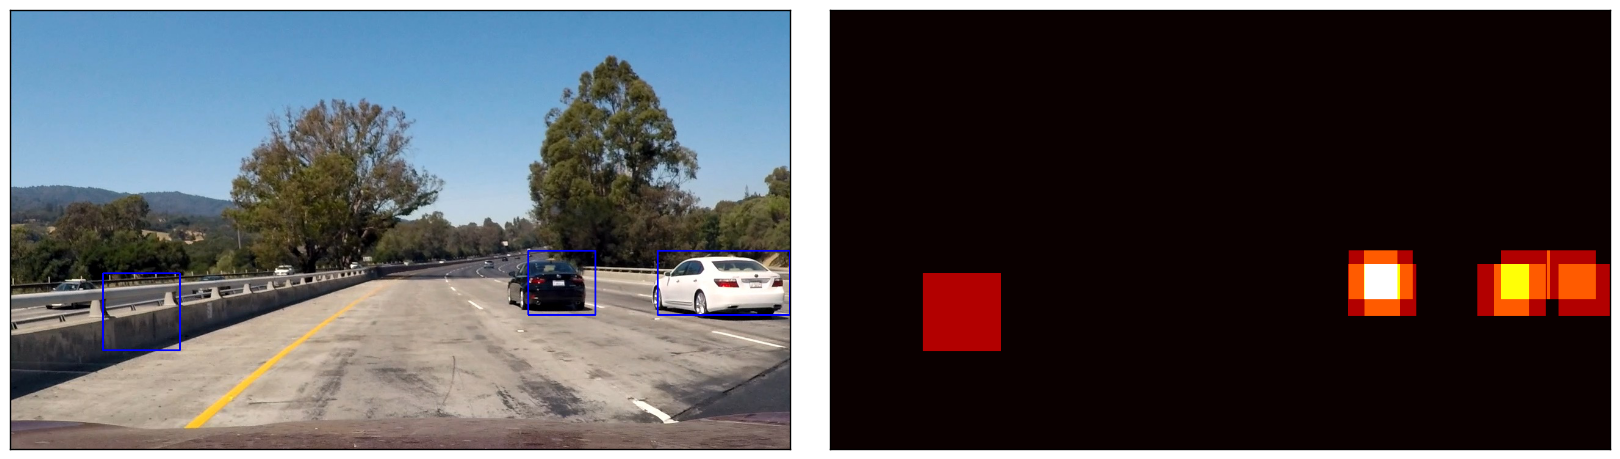

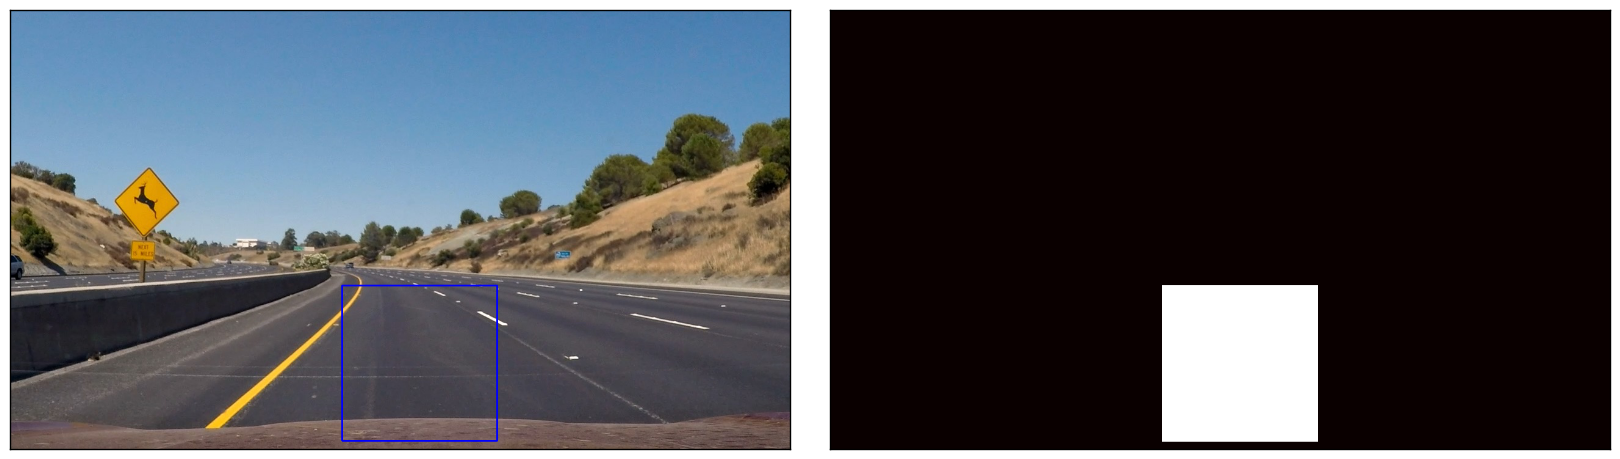

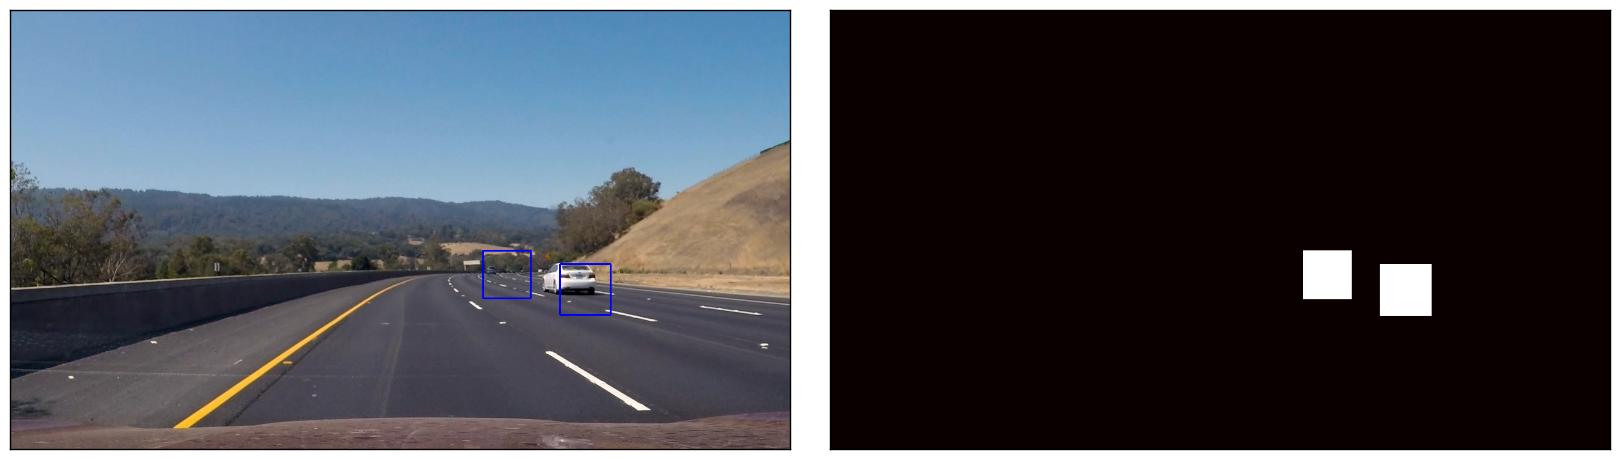

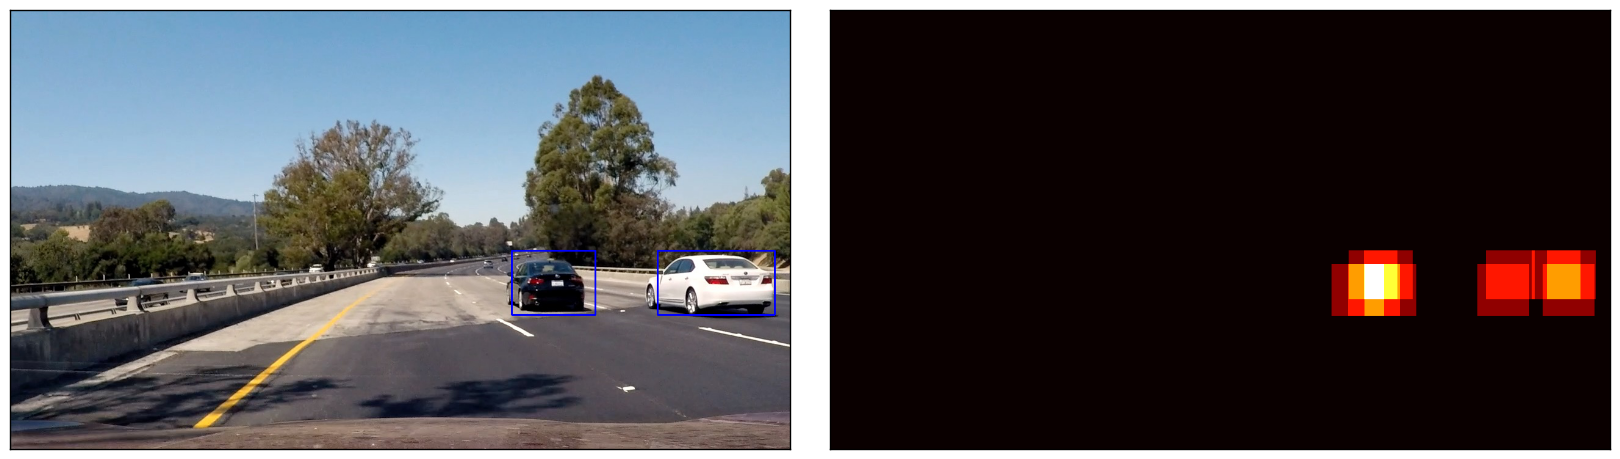

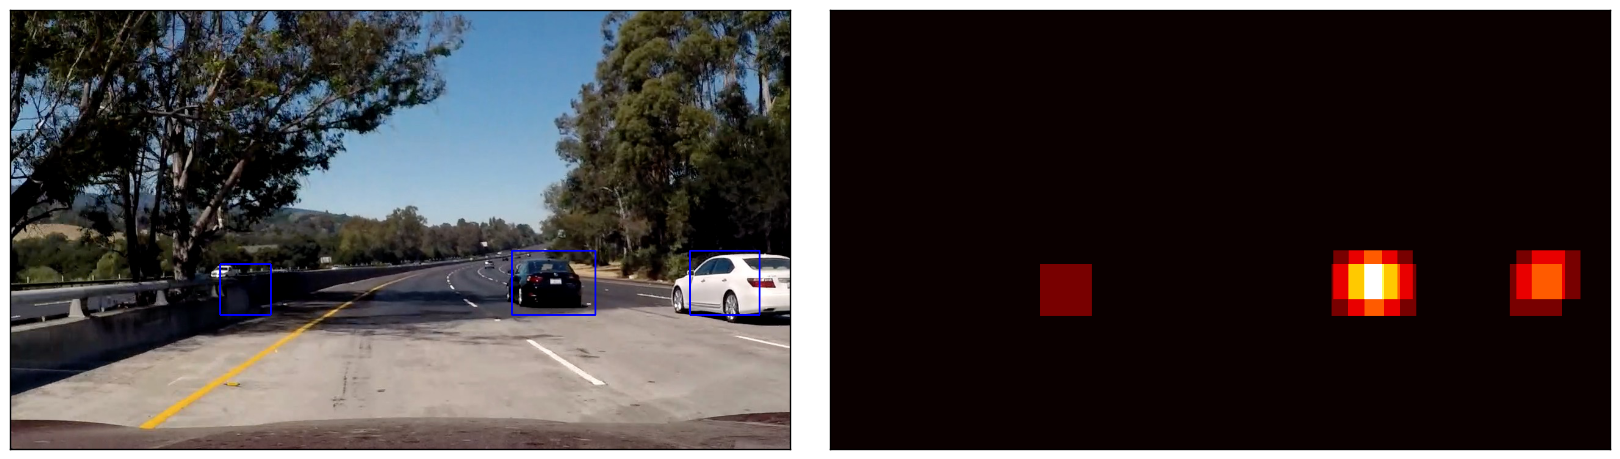

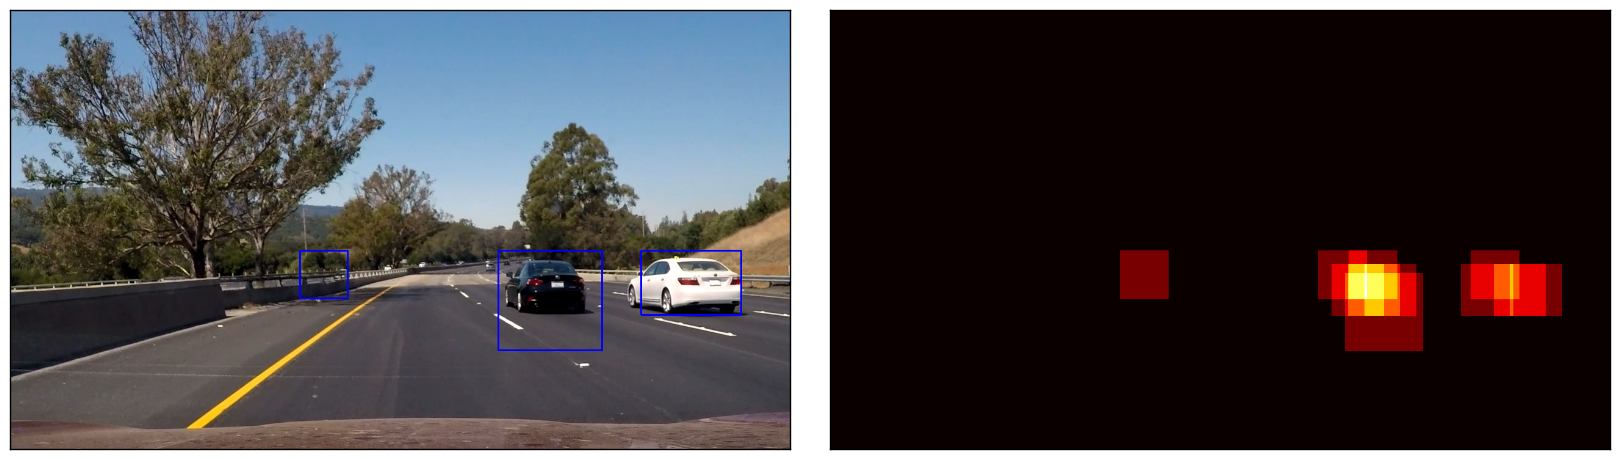

In [27]:
for image_name in glob.glob('test_images/*.jpg'):
    image = mpimg.imread(image_name)
    tracker = CarTrack(X_scale, svc, image)
    tracker.workflow(image, draw=True)

    fig = plt.figure(figsize = (16, 8))
    fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)

    axis = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
    axis.imshow(image)
    axis = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
    axis.imshow(tracker.heatmap, cmap='hot')
    plt.show()

## Video

In [25]:
video_name = 'test_output.mp4'
video = VideoFileClip("test_video.mp4")
tracker = CarTrack(X_scale, svc, video.get_frame(0))
video_output = video.fl_image(tracker.workflow)
%time video_output.write_videofile(video_name, audio=False)

[MoviePy] >>>> Building video test_output.mp4
[MoviePy] Writing video test_output.mp4


 97%|█████████▋| 38/39 [01:20<00:01,  1.84s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_output.mp4 

CPU times: user 1min 4s, sys: 10.4 s, total: 1min 14s
Wall time: 1min 21s


In [29]:
video_name = 'P5_output.mp4'
video = VideoFileClip("project_video.mp4")
tracker = CarTrack(X_scale, svc, video.get_frame(0))
video_output = video.fl_image(tracker.workflow)
%time video_output.write_videofile(video_name, audio=False)

[MoviePy] >>>> Building video P5_output.mp4
[MoviePy] Writing video P5_output.mp4



100%|█████████▉| 1260/1261 [44:02<00:01,  1.96s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: P5_output.mp4 

CPU times: user 35min 57s, sys: 5min 54s, total: 41min 51s
Wall time: 44min 4s
